# 1: Preprocessing
Load the [Heart Failure Clinical Records Dataset](https://archive.ics.uci.edu/ml/datasets/Heart%2Bfailure%2Bclinical%2Brecords) from `heart.csv`. Store `DEATH_EVENT` as the target. Store the other quantitative variables except `time` as predictors. Perform a log transformation on the predictors to make them compatible with Gaussian modeling. Divide the predictors into two sets for `DEATH_EVENT=0` and `DEATH_EVENT=1` respectively.

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('heart.csv')

X = dataset.drop(["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "time", "DEATH_EVENT"], axis=1)
X = np.log(X)

y = dataset["DEATH_EVENT"]

indices_0 = y.index[y==0]
indices_1 = y.index[y==1]

X_0 = X.iloc[indices_0, :]
X_1 = X.iloc[indices_1, :]

In [2]:
display(X)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,4.317488,6.366470,2.995732,12.487485,0.641854,4.867534
1,4.007333,8.969669,3.637586,12.481270,0.095310,4.912655
2,4.174387,4.983607,2.995732,11.995352,0.262364,4.859812
3,3.912023,4.709530,2.995732,12.254863,0.641854,4.919981
4,4.174387,5.075174,2.995732,12.697715,0.993252,4.753590
...,...,...,...,...,...,...
294,4.127134,4.110874,3.637586,11.951180,0.095310,4.962845
295,4.007333,7.506592,3.637586,12.506177,0.182322,4.934474
296,3.806662,7.630461,4.094345,13.517105,-0.223144,4.927254
297,3.806662,7.788626,3.637586,11.849398,0.336472,4.941642


In [3]:
display(y)

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

# 2: Model Fitting
Create Gaussian Naive Bayes, LDA, and QDA prediction functions for models fit on all predictors to predict `DEATH_EVENT`. Infer prior probabilities from class proportions.

In [4]:
from scipy.stats import multivariate_normal

# prior_0 = X_0.shape[0] / X.shape[0]
# prior_1 = X_1.shape[0] / X.shape[0]

prior_0 = np.sum(y==0) / y.shape[0]
prior_1 = np.sum(y==1) / y.shape[0]

Sigma = X.cov()
Sigma_0 = X_0.cov()
Sigma_1 = X_1.cov()
var_0 = X_0.var()
var_1 = X_1.var()

mu_0 = X_0.mean()
mu_1 = X_1.mean()

In [10]:
print(prior_0)
print(prior_1)

0.6789297658862876
0.3210702341137124


In [5]:
def gnb_predict(X):
    likelihood_0 = multivariate_normal.pdf(X, mean=mu_0, cov=var_0)
    likelihood_1 = multivariate_normal.pdf(X, mean=mu_1, cov=var_1)
    # NB: These are posteriors without the normalization terms.
    posterior_0 = prior_0 * likelihood_0
    posterior_1 = prior_1 * likelihood_1 
    # Syntactic trick.
    return (posterior_1 > posterior_0).astype(int)

def lda_predict_1(X):
    likelihood_0 = multivariate_normal.pdf(X, mean=mu_0, cov=Sigma)
    likelihood_1 = multivariate_normal.pdf(X, mean=mu_1, cov=Sigma)
    posterior_0 = prior_0 * likelihood_0
    posterior_1 = prior_1 * likelihood_1
    return (posterior_1 > posterior_0).astype(int)
    
def qda_predict_1(X):
    likelihood_0 = multivariate_normal.pdf(X, mean=mu_0, cov=Sigma_0)
    likelihood_1 = multivariate_normal.pdf(X, mean=mu_1, cov=Sigma_1)
    posterior_0 = prior_0 * likelihood_0
    posterior_1 = prior_1 * likelihood_1
    return (posterior_1 > posterior_0).astype(int)

# Alternative implementations using explicit log posterior formulas.

def lda_predict_2(X):
    # NB: These are log posteriors without the terms that cancel.
    log_posterior_0 = np.log(prior_0) - (1/2)*np.sum((X - mu_0).values @ np.linalg.inv(Sigma) * (X - mu_0).values, axis=1)
    log_posterior_1 = np.log(prior_1) - (1/2)*np.sum((X - mu_1).values @ np.linalg.inv(Sigma) * (X - mu_1).values, axis=1)
    return (log_posterior_0 - log_posterior_1 < 0).astype(int)

def qda_predict_2(X):
    log_posterior_0 = np.log(prior_0) - (1/2)*np.log(np.linalg.det(Sigma_0)) - (1/2)*np.sum((X - mu_0).values @ np.linalg.inv(Sigma_0) * (X - mu_0).values, axis=1)
    log_posterior_1 = np.log(prior_1) - (1/2)*np.log(np.linalg.det(Sigma_1)) - (1/2)*np.sum((X - mu_1).values @ np.linalg.inv(Sigma_1) * (X - mu_1).values, axis=1)
    return (log_posterior_0 - log_posterior_1 < 0).astype(int)

In [6]:
print(np.alltrue(lda_predict_1(X)==lda_predict_2(X)))
print(np.alltrue(qda_predict_1(X)==qda_predict_2(X)))

# NB: The sklearn implementations differ.

True
True


# 3: Model Asessment
For each model, print the accuracy.

In [7]:
print("GNB:", np.sum(gnb_predict(X) == y) / len(y))
print("LDA:", np.sum(lda_predict_1(X) == y) / len(y))
print("QDA:", np.sum(qda_predict_1(X) == y) / len(y))

GNB: 0.7792642140468228
LDA: 0.7625418060200669
QDA: 0.7692307692307693


Assess whether the GNB, LDA, and QDA assumptions hold.

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
age,1.000000,-0.050282,0.078937,-0.133014,0.186379,-0.023404
creatinine_phosphokinase,-0.050282,1.000000,-0.078121,-0.029516,-0.063039,-0.073853
ejection_fraction,0.078937,-0.078121,1.000000,0.064572,-0.123291,0.103866
platelets,-0.133014,-0.029516,0.064572,1.000000,-0.046979,-0.047690
serum_creatinine,0.186379,-0.063039,-0.123291,-0.046979,1.000000,-0.209316
serum_sodium,-0.023404,-0.073853,0.103866,-0.047690,-0.209316,1.000000


,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
age,1.000000,-0.231518,0.257411,0.090547,0.126178,0.051528
creatinine_phosphokinase,-0.231518,1.000000,-0.002264,0.038797,-0.123042,0.185069
ejection_fraction,0.257411,-0.002264,1.000000,0.034633,0.118348,0.196832
platelets,0.090547,0.038797,0.034633,1.000000,-0.046436,0.157854
serum_creatinine,0.126178,-0.123042,0.118348,-0.046436,1.000000,-0.204203
serum_sodium,0.051528,0.185069,0.196832,0.157854,-0.204203,1.000000


False


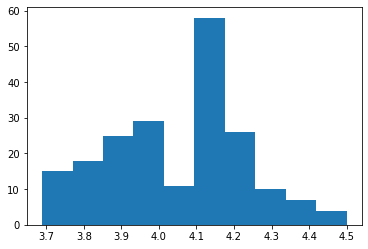

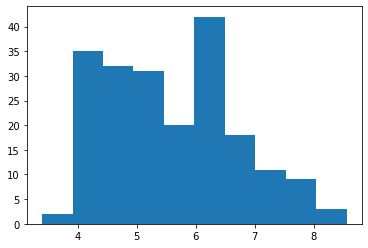

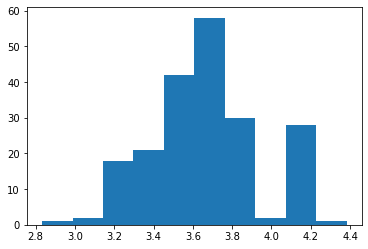

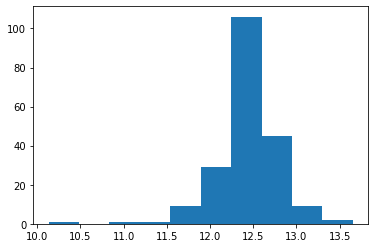

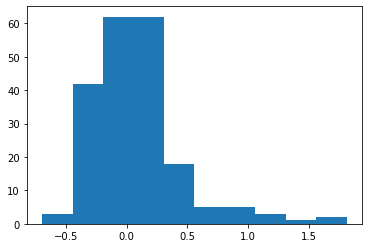

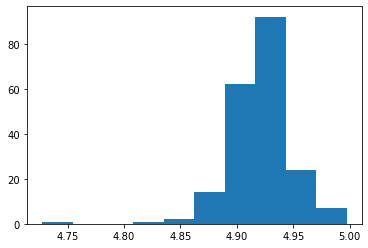

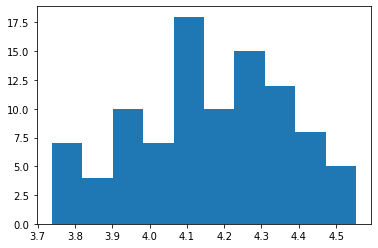

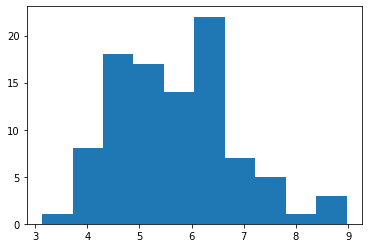

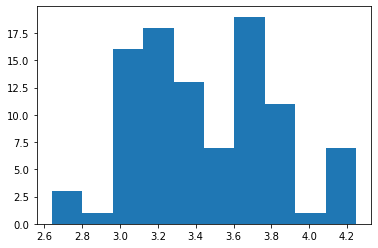

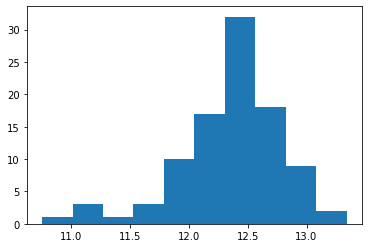

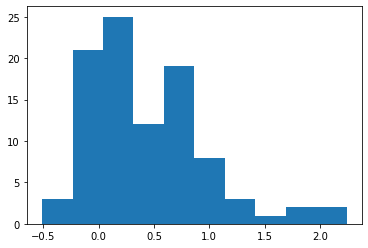

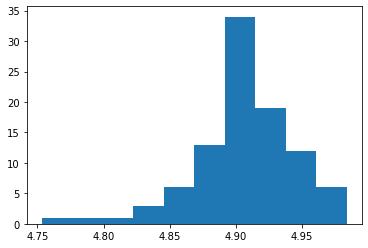

In [8]:
import matplotlib.pyplot as plt

# The predictors have some correlation within the classes (against GNB).
display(X_0.corr())
display(X_1.corr())

# The covariances within the classes differ (against LDA).
print(np.allclose(Sigma_0, Sigma_1))

# The predictors are not all Gaussian within the classes (against all).
for k in range(X_0.shape[1]):
    plt.hist(X_0.iloc[:,k])
    plt.show()
for k in range(X_1.shape[1]):
    plt.hist(X_1.iloc[:,k])
    plt.show()
    
# Despite the assumptions being violated, the models still perform better than random classification.